## CYGNSS Okavango: Regional Aggregation and Front-Normal Velocity Tools

This version centralizes imports and utilities, and validates against nbformat schema.


- Merges daily CYGNSS Okavango NetCDF tiles into a single time–lat–lon DataArray, with quick sanity checks and exploratory plots.

- Provides reusable utilities for DSWE-style wet masks, regionmask polygons, and monthly composites over user-defined regions.

- Computes wet/dry front-normal and channel-parallel velocities between two dates to analyze Okavango flood-pulse dynamics along channels.


In [2]:
# One-time setup: uncomment and run if 'from src...' imports fail
# %pip install -e /Users/octaviacrompton/Projects/dswe-inman-lyons -q

In [3]:
# Combined imports (deduplicated)
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path
from pyproj import Transformer
from shapely.geometry import box, LineString, MultiLineString, Point
from shapely.ops import linemerge
from typing import Iterable, List, Tuple
import calendar
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import regionmask
import warnings
import xarray as xr

from src.gee_utils import ee_init
from src.figures import save_figure

In [4]:
# Import analysis utilities from the shared module
# (replaces ~1160 lines of inline function definitions)
from src.okavango_fronts import (
    _ensure_time_coord,
    _find_lat_lon_names,
    _infer_mask,
    _normalize_dims,
    _open_dataset_robust,
    _pick_var_with_latlon,
    classify_front_direction,
    front_normal_velocity,
    front_speed_along_channels,
    plot_parallel_velocity_with_channels,
    plot_three_panel,
    stats,
    velocity_parallel_to_nearest_channel_field,
)

In [5]:
# NC_PATH   = Path("../data/cygnss_okavango_daily/cygnss_okavango_daily_merged.nc")

In [6]:
# --- Merge individual files (NetCDFs) directly into one DataArray ----------------
# ====== USER SETTINGS ======
INPUT_DIR   = Path('../data/cygnss_okavango_daily/')             # folder containing per-file NetCDFs
GLOB        = "*.nc"                         # glob to match files
VAR_NAME    = None                           # set to variable name (str) to force; or None to auto-pick
CHUNKS      = {"time": -1, "lat": 512, "lon": 512}  # tweak for your data/compute

# Override module-level config for this dataset's conventions
import src.okavango_fronts as _of
_of.ENGINE_TRY  = ("netcdf4", "h5netcdf", "scipy")
_of.STRICT_TIME_FROM_FILENAME = False            # set True if files lack a 'time' coord
_of.TIME_REGEX  = r"(\d{4})(\d{2})(\d{2})"       # used only if STRICT_TIME_FROM_FILENAME is True

# ====== Collect, open, normalize, and concat ======
files = sorted(INPUT_DIR.glob(GLOB))
if not files:
    raise FileNotFoundError(f"No files matched {INPUT_DIR / GLOB}")
parts = []
skipped = 0
for p in files:
    try:
        ds_i = _open_dataset_robust(p)
        # find names
        lat_name, lon_name = _find_lat_lon_names(ds_i)
        varname = VAR_NAME or _pick_var_with_latlon(ds_i, lat_name, lon_name)
        da_i = ds_i[varname]
        # ensure time exists (singleton if needed)
        time_name = next((d for d in da_i.dims if d.lower() == "time"), None)
        if time_name is None:
            da_i = _ensure_time_coord(da_i, p)
            time_name = "time"
        # normalize dims and optionally chunk
        da_i = _normalize_dims(da_i, time_name, lat_name, lon_name)
        if CHUNKS:
            da_i = da_i.chunk(CHUNKS)
        parts.append(da_i)
    except Exception as e:
        skipped += 1
        warnings.warn(f"Skipping {p.name}: {e}")
if not parts:
    raise RuntimeError("All files failed to open or contained no usable variables.")
# Concatenate over time (auto-align lat/lon by coordinate equality)
da = xr.concat(parts, dim="time", join="exact")  # change join to 'override' or 'outer' if grids differ slightly
# Optional: sort by time & drop duplicate NaT rows if dummy times were used
if da.indexes.get("time", None) is not None:
    da = da.sortby("time")
    if np.issubdtype(da.time.dtype, np.datetime64):
        # drop exact duplicates in time if any
        _, unique_idx = np.unique(da.time.values, return_index=True)
        if len(unique_idx) != da.sizes["time"]:
            da = da.isel(time=np.sort(unique_idx))
print(f"Merged {len(parts)} files; skipped {skipped}.")
print("Final shape:", dict(da.sizes))   # {'time': ..., 'lat': ..., 'lon': ...}

Merged 1 files; skipped 0.
Final shape: {'time': 2590, 'lat': 200, 'lon': 241}


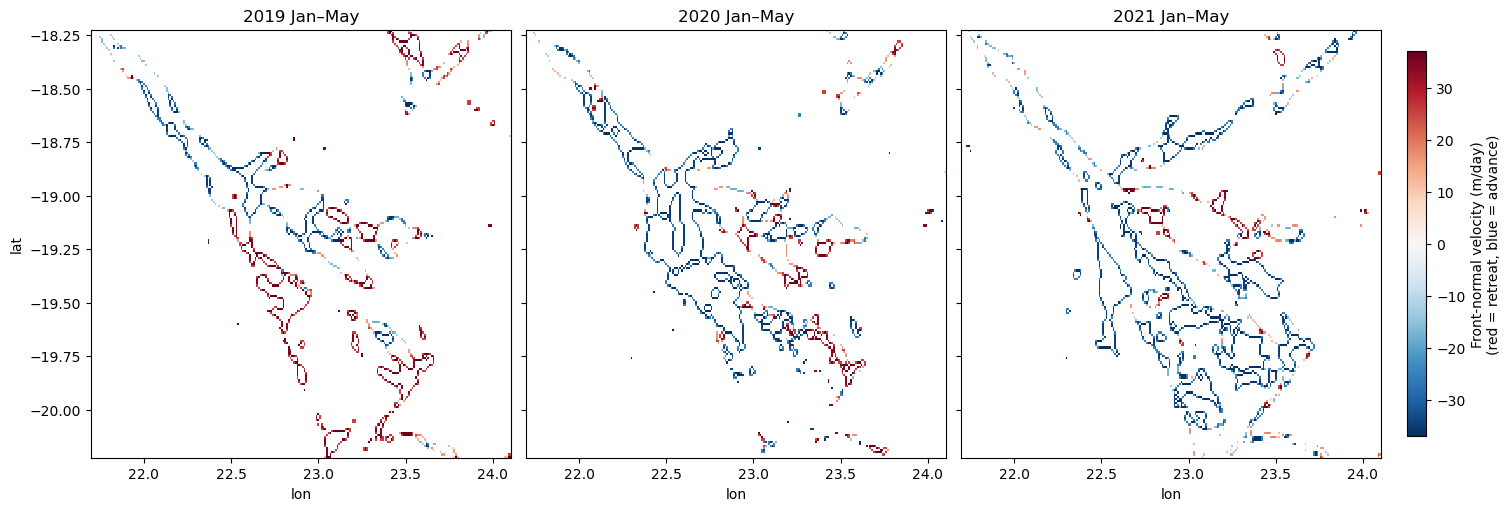

In [7]:
import matplotlib.colors as mcolors
windows = [
    ("2019-01-01", "2019-05-01", "2019 Jan–May"),
    ("2020-01-01", "2020-05-01", "2020 Jan–May"),
    ("2021-01-01", "2021-05-01", "2021 Jan–May"),
]

# compute v_normal for each window
v_list = []
for start, end, _ in windows:
    ds = front_normal_velocity(
        da, start, end,
        front_value=0.5,
        bandwidth=0.05,
        smooth_px=1
    )
    v_list.append(ds["v_normal"])

# shared, robust, symmetric limits across all panels
all_vals = np.concatenate([v.values.ravel() for v in v_list])
all_vals = all_vals[np.isfinite(all_vals)]
lim = np.quantile(np.abs(all_vals), 0.98)   # tweak (e.g., 0.95) or set lim=30 manually
norm = mcolors.TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)

fig, axes = plt.subplots(
    1, 3, figsize=(15, 5),
    sharex=True, sharey=True,
    constrained_layout=True
)

for ax, v, (_, _, title) in zip(axes, v_list, windows):
    im = v.plot(
        ax=ax,
        cmap="RdBu_r",
        norm=norm,
        add_colorbar=False
    )
    ax.set_title(title)
    ax.set_xlabel("lon")

axes[0].set_ylabel("lat")
for ax in axes[1:]:
    ax.set_ylabel("")

cbar = fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
cbar.set_label("Front-normal velocity (m/day)\n(red = retreat, blue = advance)")

plt.show()


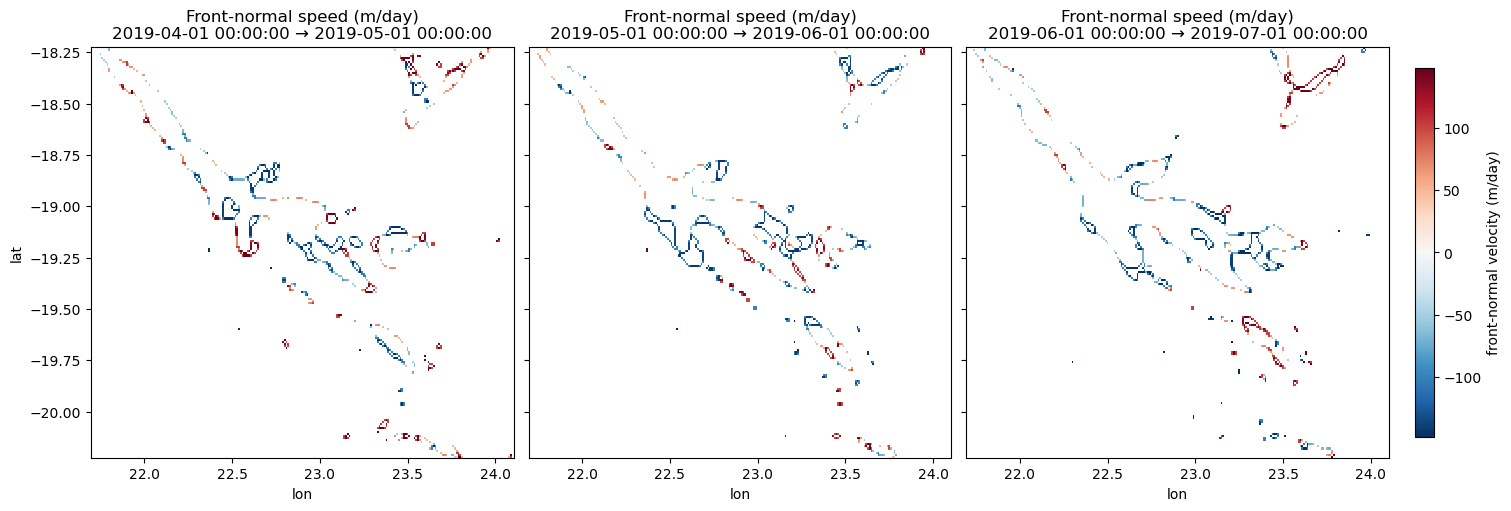

In [8]:
import numpy as np


windows = [
    ("2019-04-01", "2019-05-01"),
    ("2019-05-01", "2019-06-01"),
    ("2019-06-01", "2019-07-01"),
]

v_list, titles = [], []
for t1, t2 in windows:
    ds = front_normal_velocity(da, t1, t2, front_value=0.5, bandwidth=0.05, smooth_px=1)
    v_list.append(ds["v_normal"])
    titles.append(f"{ds.attrs['t1']} → {ds.attrs['t2']}")

# shared, robust, symmetric limits
all_vals = np.concatenate([v.values.ravel() for v in v_list])
all_vals = all_vals[np.isfinite(all_vals)]
lim = np.quantile(np.abs(all_vals), 0.98)
norm = mcolors.TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, constrained_layout=True)

for ax, v, title in zip(axes, v_list, titles):
    im = v.plot(ax=ax, cmap="RdBu_r", norm=norm, add_colorbar=False)
    ax.set_title(f"Front-normal speed (m/day)\n{title}")
    ax.set_xlabel("lon")

axes[0].set_ylabel("lat")
for ax in axes[1:]:
    ax.set_ylabel("")

cbar = fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
cbar.set_label("front-normal velocity (m/day)")

plt.show()


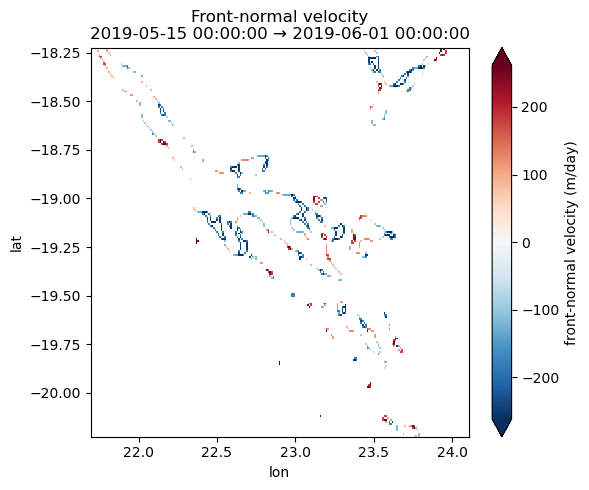

In [9]:
# --- Example usage (adjust dates and front_value to your variable) ---
ds_perp = front_normal_velocity(da, "2019-05-15", "2019-06-01", front_value=0.5, bandwidth=0.05, smooth_px=1)

fig, ax = plt.subplots(figsize=(6, 5))
ds_perp["v_normal"].plot(
    ax=ax,
    cmap="RdBu_r",
    robust=True,
    cbar_kwargs={"label": "front-normal velocity (m/day)"}
)
ax.set_title(f"Front-normal velocity\n{ds_perp.attrs['t1']} → {ds_perp.attrs['t2']}")
plt.tight_layout()
plt.show()


In [ ]:
# --- Example usage (adjust dates and front_value to your variable) ---
ds_perp = front_normal_velocity(da, "2019-05-15", "2019-06-01", front_value=0.5, bandwidth=0.05, smooth_px=1)
ds_perp["v_normal"].plot(cmap="RdBu_r", robust=True)  # m/day; red/blue = retreat/advance
# ds_perp["mask_front"].plot()


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import regionmask
from shapely.ops import unary_union

# --- Load basin regions ------------------------------------------------------
gdf_split = gpd.read_file("../data/regions/okavango_regions.gpkg")
# ensure a basin_label column exists
if "basin_label" not in gdf_split.columns:
    gdf_split["basin_label"] = gdf_split["name"]

# --- Alias watermask & derive spatial extent from da -------------------------
wm = da
lon_min = float(da[lon_name].min());  lon_max = float(da[lon_name].max())
lat_min = float(da[lat_name].min());  lat_max = float(da[lat_name].max())

# --- Study area polygon (union of all basin geometries) ----------------------
study_area = unary_union(gdf_split.geometry)

# --- Config ------------------------------------------------------------------
topN     = 5     # label the N basins with highest mean inundated area
map_time = None  # set to e.g. "2020-06-01" to pick a specific time slice

# --- Time series: mean water fraction per basin per time step ----------------
regions  = regionmask.from_geopandas(gdf_split, names="basin_label")
mask3d   = regions.mask_3D(da[lon_name].values, da[lat_name].values)  # (region, lat, lon)

# Iterate over the actual region indices regionmask assigned (may skip dupes)
region_nums = mask3d.region.values  # integer indices into gdf_split
ts_dict = {}
for reg_i in region_nums:
    label = gdf_split.iloc[int(reg_i)]["basin_label"]
    basin_mask = mask3d.sel(region=reg_i)
    ts_dict[label] = da.where(basin_mask).mean(dim=[lat_name, lon_name]).values

ts = pd.DataFrame(ts_dict, index=pd.DatetimeIndex(da["time"].values))
print(f"ts shape: {ts.shape}  |  basins: {list(ts.columns)}")


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

gdf_regions = gpd.read_file("../data/regions/okavango_regions.gpkg")
print(gdf_regions[["name", "geometry"]].to_string())
print(f"\nCRS: {gdf_regions.crs} | rows: {len(gdf_regions)}")

fig, ax = plt.subplots(figsize=(8, 6))
gdf_regions.plot(ax=ax, facecolor="lightblue", edgecolor="black", linewidth=0.8, alpha=0.5)

for _, row in gdf_regions.iterrows():
    p = row.geometry.centroid
    if not row.geometry.contains(p):
        p = row.geometry.representative_point()
    ax.text(
        p.x, p.y, row["name"],
        ha="center", va="center", fontsize=8,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

ax.set_title("okavango_regions.gpkg")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


In [ ]:
# --- Map plot: pick a single 2D time slice + labels clipped to data extent

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as pe
from shapely.geometry import box

# ---- choose which basins to label (topN by mean inundated area) ----
top_cols = ts.mean().sort_values(ascending=False).head(topN).index.tolist()

# ---- pick a SINGLE time slice robustly (always returns 2D lat×lon) ----
time_index = pd.DatetimeIndex(wm["time"].values)

if map_time is None:
    tidx = -1
else:
    tidx = time_index.get_indexer([pd.Timestamp(map_time)], method="nearest")[0]

wm_map = wm.isel(time=tidx)
tsel = time_index[tidx]

extent_box = box(lon_min, lat_min, lon_max, lat_max)

# ---- plot ----
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={"projection": ccrs.PlateCarree()})

wm_map.plot.pcolormesh(
    ax=ax,
    x=lon_name, y=lat_name,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap="Blues",
)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, facecolor="none")
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.coastlines(linewidth=0.3)

# ---- draw watershed delineations ----
for _, row in gdf_split.iterrows():
    ax.add_geometries(
        [row.geometry],
        crs=ccrs.PlateCarree(),
        facecolor="none",
        edgecolor="gold",
        linewidth=1.0,
        zorder=5,
    )

# ---- labels: all top basins ----
for _, r in gdf_split[gdf_split["basin_label"].isin(top_cols)].iterrows():
    g = r.geometry.intersection(extent_box)
    if g.is_empty:
        continue
    p = g.centroid
    if not g.contains(p):
        p = g.representative_point()
    ax.text(
        p.x, p.y, r["basin_label"],
        transform=ccrs.PlateCarree(),
        ha="center", va="center",
        fontsize=8,
        zorder=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

ax.set_title(f"CYGNSS watermask + basins — {pd.Timestamp(tsel).strftime('%Y-%m')}")
plt.show()


In [ ]:
# Grab the first time slice
da0 = da.isel(time=10)
# Optional: quick stats in the console
t0 = pd.to_datetime(da0.time.values).strftime("%Y-%m-%d %H:%M:%S") if "time" in da0.coords else "unknown time"
vmin = np.nanmin(da0.values)
vmax = np.nanmax(da0.values)
print(f"First image time: {t0} | min={vmin:.3g}, max={vmax:.3g}")
# Plot (uses lat/lon coords if present)
fig, ax = plt.subplots(figsize=(7, 5))
da0.plot.pcolormesh(ax=ax, shading="auto", cmap="Blues", add_colorbar=False)  # robust to ascending/descending lat
ax.set_title(f"{da0.name or 'variable'} at {t0}")
ax.set_aspect("equal")  # feel free to comment out if you prefer auto aspect
plt.tight_layout()
plt.show()

In [ ]:
# --- Config -------------------------------------------------------------------
PLOT_ASPECT_EQUAL = True
CBAR_KW = {"shrink": 0.7, "aspect": 30, "pad": 0.02}
# --- Choose the two times -----------------------------------------------------
# Option A: by integer index
t1_idx, t2_idx = 0, 31
# Option B: by datetime-like labels (uncomment if you prefer)
# t1_lbl, t2_lbl = "2019-07-01", "2020-07-01"
# --- Grab slices (works whether you use indices or labels) --------------------
if "time" not in da.dims:
    raise ValueError("This DataArray has no 'time' dimension.")
# Index-based
da1 = da.isel(time=t1_idx)
da2 = da.isel(time=t2_idx)
# Label-based (override above if using labels)
# da1 = da.sel(time=np.datetime64(t1_lbl))
# da2 = da.sel(time=np.datetime64(t2_lbl))
# Date-only strings for titles/labels
t1_dt = pd.to_datetime(da1.time.values)
t2_dt = pd.to_datetime(da2.time.values)
t1 = t1_dt.strftime("%Y-%m-%d")
t2 = t2_dt.strftime("%Y-%m-%d")
# --- Quick sanity stats for each slice ---------------------------------------
stats(f"Slice @ {t1}", da1)
stats(f"Slice @ {t2}", da2)
# --- Difference (t2 - t1) ----------------------------------------------------
diff = da2 - da1
diff.name = (da.name or "variable") + "_diff"
v = np.asarray(diff.values)
print(f"Diff ({t2} - {t1}): min={np.nanmin(v):.3g}, max={np.nanmax(v):.3g}, mean={np.nanmean(v):.3g}")
# --- Plot the two slices + difference ----------------------------------------
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True,
                         sharex=True, sharey=True)
da1.plot.pcolormesh(ax=axes[0], shading="auto", cmap="Blues", add_colorbar=False)
axes[0].set_title(t1)
if PLOT_ASPECT_EQUAL:
    axes[0].set_aspect("equal")
da2.plot.pcolormesh(ax=axes[1], shading="auto", cmap="Blues", add_colorbar=False)
axes[1].set_title(t2)
if PLOT_ASPECT_EQUAL:
    axes[1].set_aspect("equal")
# Mask zeros so they render as transparent (white background shows through)
# Custom diverging: tan (-1, loss) → white (0) → steel blue (+1, expansion)
LOSS_COLOR = "#C4A882"   # tan → water loss
GAIN_COLOR = "#4A7BA1"   # steel blue → water expansion
cmap_custom = LinearSegmentedColormap.from_list(
    "tan_steelblue", [LOSS_COLOR, "#FFFFFF", GAIN_COLOR]
)
diff_masked = diff.where(diff != 0)
diff_norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
diff_masked.plot.pcolormesh(
    ax=axes[2],
    shading="auto",
    cmap=cmap_custom,
    norm=diff_norm,
    add_colorbar=False,
)
axes[2].set_title(f"Δ ({t2} − {t1})")
if PLOT_ASPECT_EQUAL:
    axes[2].set_aspect("equal")
# Legend colors match the custom colormap endpoints
loss_patch = mpatches.Patch(color=LOSS_COLOR, label="water loss")
gain_patch = mpatches.Patch(color=GAIN_COLOR, label="water expansion")
axes[2].legend(handles=[loss_patch, gain_patch], loc="lower left", fontsize=12, framealpha=0.8)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

def _edge_mean(da, t, days=10, side="after"):
    t = pd.Timestamp(t)
    if side == "after":
        sl = slice(t, t + pd.Timedelta(days=days - 1))
    else:  # "before"
        sl = slice(t - pd.Timedelta(days=days - 1), t)
    return da.sel(time=sl).mean("time", skipna=True)

def expansion_contraction(da, t1, t2, front_value=0.5, edge_days=10):
    early = _edge_mean(da, t1, days=edge_days, side="after")
    late  = _edge_mean(da, t2, days=edge_days, side="before")
    return (late >= front_value).astype("i1") - (early >= front_value).astype("i1")

windows = [
    ("2019-01-01", "2019-02-01", "2019 Jan–Feb"),
    ("2020-01-01", "2020-02-01", "2020 Jan–Feb"),
    ("2021-01-01", "2021-02-01", "2021 Jan–Feb"),
]

deltas = [expansion_contraction(da, t1, t2, front_value=0.5, edge_days=10)
          for t1, t2, _ in windows]

fig, axes = plt.subplots(
    1, 3, figsize=(15, 5),
    sharex=True, sharey=True,
    constrained_layout=True
)

# Custom diverging: tan (-1, loss) → white (0) → steel blue (+1, expansion)
LOSS_COLOR = "#C4A882"   # tan → water loss
GAIN_COLOR = "#4A7BA1"   # steel blue → water expansion
cmap_custom = LinearSegmentedColormap.from_list(
    "tan_steelblue", [LOSS_COLOR, "#FFFFFF", GAIN_COLOR]
)
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for ax, d, (_, _, title) in zip(axes, deltas, windows):
    # Mask zeros so they render as transparent (white background shows through)
    d_masked = d.where(d != 0)
    d_masked.plot(ax=ax, cmap=cmap_custom, norm=norm, add_colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("lon")

axes[0].set_ylabel("lat")
for ax in axes[1:]:
    ax.set_ylabel("")

# Legend matches the custom colormap endpoints
loss_patch = mpatches.Patch(color=LOSS_COLOR, label="water loss")
gain_patch = mpatches.Patch(color=GAIN_COLOR, label="water expansion")
axes[-1].legend(handles=[loss_patch, gain_patch], loc="lower left", fontsize=12, framealpha=0.8)

plt.show()


In [ ]:
# --- Config -------------------------------------------------------------------
PLOT_ASPECT_EQUAL = True
CBAR_KW = {"shrink": 0.75, "aspect": 30, "pad": 0.02}
# --- Choose the two times -----------------------------------------------------
# Option A: by integer index
t1_idx, t2_idx = 3, 10
# Option B: by datetime-like labels (uncomment if you prefer)
# t1_lbl, t2_lbl = "2019-07-01", "2020-07-01"
# --- Grab slices (works whether you use indices or labels) --------------------
if "time" not in da.dims:
    raise ValueError("This DataArray has no 'time' dimension.")
# Index-based
da1 = da.isel(time=t1_idx)
da2 = da.isel(time=t2_idx)
# Label-based (override above if using labels)
# da1 = da.sel(time=np.datetime64(t1_lbl))
# da2 = da.sel(time=np.datetime64(t2_lbl))
# Date-only strings for titles/labels
t1_dt = pd.to_datetime(da1.time.values)
t2_dt = pd.to_datetime(da2.time.values)
t1 = t1_dt.strftime("%Y-%m-%d")
t2 = t2_dt.strftime("%Y-%m-%d")
# --- Quick sanity stats for each slice ---------------------------------------
stats(f"Slice @ {t1}", da1)
stats(f"Slice @ {t2}", da2)
# --- Difference (t2 - t1) ----------------------------------------------------
diff = da2 - da1
diff.name = (da.name or "variable") + "_diff"
v = np.asarray(diff.values)
print(f"Diff ({t2} - {t1}): min={np.nanmin(v):.3g}, max={np.nanmax(v):.3g}, mean={np.nanmean(v):.3g}")
# --- Plot the two slices + difference ----------------------------------------
import matplotlib.patches as mpatches
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), constrained_layout=True,
                         sharex=True, sharey=True)
da1.plot.pcolormesh(ax=axes[0], shading="auto", cmap="Blues", add_colorbar=False)
axes[0].set_title(t1)
if PLOT_ASPECT_EQUAL:
    axes[0].set_aspect("equal")
da2.plot.pcolormesh(ax=axes[1], shading="auto", cmap="Blues", add_colorbar=False)
axes[1].set_title(t2)
if PLOT_ASPECT_EQUAL:
    axes[1].set_aspect("equal")
# Mask zeros so they render as transparent (white background shows through)
# Custom diverging: tan (-1, loss) → white (0) → steel blue (+1, expansion)
LOSS_COLOR = "#C4A882"   # tan → water loss
GAIN_COLOR = "#4A7BA1"   # steel blue → water expansion
cmap_custom = LinearSegmentedColormap.from_list(
    "tan_steelblue", [LOSS_COLOR, "#FFFFFF", GAIN_COLOR]
)
diff_masked = diff.where(diff != 0)
diff_norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
diff_masked.plot.pcolormesh(
    ax=axes[2],
    shading="auto",
    cmap=cmap_custom,
    norm=diff_norm,
    add_colorbar=False,
)
axes[2].set_title(f"Δ ({t2} − {t1})")
if PLOT_ASPECT_EQUAL:
    axes[2].set_aspect("equal")
# Legend colors match the custom colormap endpoints
loss_patch = mpatches.Patch(color=LOSS_COLOR, label="water loss")
gain_patch = mpatches.Patch(color=GAIN_COLOR, label="water expansion")
axes[2].legend(handles=[loss_patch, gain_patch], loc="lower left", fontsize=12, framealpha=0.8)


In [ ]:

# ── Compute FNV for every consecutive month pair, then composite by calendar month ──
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Patch
import calendar
from pathlib import Path

# ── Cache paths ───────────────────────────────────────────────────────────────
PROCESSED_DIR = Path(INPUT_DIR).parent / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CACHE_EXP = PROCESSED_DIR / "fnv_monthly_expansion.nc"
CACHE_CON = PROCESSED_DIR / "fnv_monthly_contraction.nc"

FORCE_RECOMPUTE = False   # set True to ignore cache and recompute

MONTH_NAMES = [calendar.month_abbr[m] for m in range(1, 13)]

# ── Load from cache if available ──────────────────────────────────────────────
if not FORCE_RECOMPUTE and CACHE_EXP.exists() and CACHE_CON.exists():
    print(f"Loading cached results from {PROCESSED_DIR}")
    v_stack_monthly_exp = xr.open_dataarray(CACHE_EXP)
    v_stack_monthly_con = xr.open_dataarray(CACHE_CON)
    months_available = v_stack_monthly_exp.calendar_month.values.tolist()
    expansion_monthly   = {m: v_stack_monthly_exp.sel(calendar_month=m).drop_vars("calendar_month")
                           for m in months_available}
    contraction_monthly = {m: v_stack_monthly_con.sel(calendar_month=m).drop_vars("calendar_month")
                           for m in months_available}
    print(f"Loaded composites for months: {months_available}")

else:
    # ── Compute from scratch ──────────────────────────────────────────────────
    time_index = pd.DatetimeIndex(da.time.values)
    month_starts = (
        pd.period_range(time_index.min(), time_index.max(), freq="M")
        .to_timestamp()
        .tolist()
    )

    v_maps = []     # list of (calendar_month_int, DataArray)
    skipped = 0
    for i in range(len(month_starts) - 1):
        t1 = month_starts[i].strftime("%Y-%m-%d")
        t2 = month_starts[i + 1].strftime("%Y-%m-%d")
        t1_data = da.sel(time=slice(t1, (month_starts[i + 1] - pd.Timedelta(days=1)).strftime("%Y-%m-%d")))
        t2_data = da.sel(time=slice(t2, (month_starts[i + 1] + pd.Timedelta(days=30)).strftime("%Y-%m-%d")))
        if t1_data.sizes["time"] == 0 or t2_data.sizes["time"] == 0:
            skipped += 1
            continue
        try:
            ds_v = front_normal_velocity(da, t1, t2, front_value=0.5, bandwidth=0.05, smooth_px=1)
            v_maps.append((month_starts[i].month, ds_v["v_normal"]))
        except Exception:
            skipped += 1

    print(f"Computed FNV for {len(v_maps)} month pairs ({skipped} skipped)")

    # ── Group by calendar month ───────────────────────────────────────────────
    expansion_monthly   = {}
    contraction_monthly = {}
    for cal_month in range(1, 13):
        maps_this_month = [v for (m, v) in v_maps if m == cal_month]
        if not maps_this_month:
            continue
        stack = xr.concat(maps_this_month, dim="year")
        expansion_monthly[cal_month]   = stack.where(stack > 0).mean("year", skipna=True)
        contraction_monthly[cal_month] = (-stack).where(stack < 0).mean("year", skipna=True)

    months_available = sorted(expansion_monthly.keys())
    v_stack_monthly_exp = xr.concat(
        [expansion_monthly[m]   for m in months_available],
        dim=pd.Index(months_available, name="calendar_month")
    )
    v_stack_monthly_con = xr.concat(
        [contraction_monthly[m] for m in months_available],
        dim=pd.Index(months_available, name="calendar_month")
    )

    # ── Save to cache ─────────────────────────────────────────────────────────
    v_stack_monthly_exp.to_netcdf(CACHE_EXP)
    v_stack_monthly_con.to_netcdf(CACHE_CON)
    print(f"Saved results to {PROCESSED_DIR}")

# ── Expose all-month means for downstream cells ───────────────────────────────
expansion_mean   = v_stack_monthly_exp.mean("calendar_month", skipna=True)
contraction_mean = v_stack_monthly_con.mean("calendar_month", skipna=True)

# ── Colour limits (shared across months) ─────────────────────────────────────
EXPAND_COLOR   = "#4A7BA1"
CONTRACT_COLOR = "#C4A882"
cmap_expand   = LinearSegmentedColormap.from_list("expand",   ["#FFFFFF", EXPAND_COLOR])
cmap_contract = LinearSegmentedColormap.from_list("contract", ["#FFFFFF", CONTRACT_COLOR])

exp_all = np.concatenate([
    expansion_monthly[m].values[np.isfinite(expansion_monthly[m].values)]
    for m in months_available
])
con_all = np.concatenate([
    contraction_monthly[m].values[np.isfinite(contraction_monthly[m].values)]
    for m in months_available
])
exp_vmax = float(np.nanpercentile(exp_all, 95))
con_vmax = float(np.nanpercentile(con_all, 95))


In [ ]:
# ── Plot a single calendar month ──────────────────────────────────────────────
PLOT_MONTH = 10   # May

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

expansion_monthly[PLOT_MONTH].plot(
    ax=axes[0], cmap=cmap_expand, vmin=0, vmax=exp_vmax, add_colorbar=True,
    cbar_kwargs={"label": "mean expansion speed (m/day)", "shrink": 0.8}
)
axes[0].set_title(f"Mean flood expansion speed — {MONTH_NAMES[PLOT_MONTH - 1]}")
axes[0].set_aspect("equal")

contraction_monthly[PLOT_MONTH].plot(
    ax=axes[1], cmap=cmap_contract, vmin=0, vmax=con_vmax, add_colorbar=True,
    cbar_kwargs={"label": "mean contraction speed (m/day)", "shrink": 0.8}
)
axes[1].set_title(f"Mean flood contraction speed — {MONTH_NAMES[PLOT_MONTH - 1]}")
axes[1].set_aspect("equal")

plt.show()


In [ ]:

# ── Re-plot with outliers removed (clip at 2nd–98th percentile per map) ──────
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, TwoSlopeNorm
from matplotlib.patches import Patch

EXPAND_COLOR   = "#4A7BA1"
CONTRACT_COLOR = "#C4A882"
PERM_COLOR     = "#0D1B2A"   # dark navy/blackish for permanently inundated

cmap_expand   = LinearSegmentedColormap.from_list("expand",   ["#FFFFFF", EXPAND_COLOR])
cmap_contract = LinearSegmentedColormap.from_list("contract", ["#FFFFFF", CONTRACT_COLOR])
cmap_diff     = LinearSegmentedColormap.from_list("diff",     [CONTRACT_COLOR, "#FFFFFF", EXPAND_COLOR])
cmap_perm     = ListedColormap([PERM_COLOR])

def clip_outliers(da, lo=0, hi=95):
    """Return da with values outside [lo, hi] percentile clamped to the threshold."""
    vals = da.values
    finite = vals[np.isfinite(vals)]
    vmin, vmax = np.nanpercentile(finite, lo), np.nanpercentile(finite, hi)
    return da.clip(min=vmin, max=vmax)

expansion_clipped   = clip_outliers(expansion_mean)
contraction_clipped = clip_outliers(contraction_mean)

# expansion − contraction: positive = expansion faster, negative = contraction faster
speed_diff = expansion_clipped - contraction_clipped

# Pixels inundated >90% of all time steps → permanently wet
perm_inund = (da > 0.5).mean("time") > 0.9
perm_overlay = perm_inund.where(perm_inund).astype(float)

# Colour limits
exp_vmax  = float(np.nanmax(expansion_clipped.values[np.isfinite(expansion_clipped.values)]))
con_vmax  = float(np.nanmax(contraction_clipped.values[np.isfinite(contraction_clipped.values)]))
diff_vals = speed_diff.values[np.isfinite(speed_diff.values)]
diff_lim  = float(np.nanpercentile(np.abs(diff_vals), 95))
diff_norm = TwoSlopeNorm(vmin=-diff_lim, vcenter=0, vmax=diff_lim)

perm_legend = [Patch(facecolor=PERM_COLOR, label="Permanently inundated (>90%)")]

# ── Figure 1: expansion + contraction ────────────────────────────────────────
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

expansion_clipped.plot(
    ax=axes1[0], cmap=cmap_expand, vmin=0, vmax=exp_vmax, add_colorbar=True,
    cbar_kwargs={"label": "mean expansion speed (m/day)", "shrink": 0.8}
)
perm_overlay.plot(ax=axes1[0], cmap=cmap_perm, vmin=0.5, vmax=1.5, add_colorbar=False)
axes1[0].set_title("Mean flood expansion speed")
axes1[0].set_aspect("equal")
axes1[0].legend(handles=perm_legend, loc="lower left", fontsize=8)

contraction_clipped.plot(
    ax=axes1[1], cmap=cmap_contract, vmin=0, vmax=con_vmax, add_colorbar=True,
    cbar_kwargs={"label": "mean contraction speed (m/day)", "shrink": 0.8}
)
perm_overlay.plot(ax=axes1[1], cmap=cmap_perm, vmin=0.5, vmax=1.5, add_colorbar=False)
axes1[1].set_title("Mean flood contraction speed")
axes1[1].set_aspect("equal")
axes1[1].legend(handles=perm_legend, loc="lower left", fontsize=8)

plt.show()

# ── Figure 2: expansion − contraction difference ─────────────────────────────
fig2, ax2 = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)

speed_diff.plot(
    ax=ax2, cmap=cmap_diff, norm=diff_norm, add_colorbar=True,
    cbar_kwargs={"label": "expansion − contraction (m/day)", "shrink": 0.8}
)
perm_overlay.plot(ax=ax2, cmap=cmap_perm, vmin=0.5, vmax=1.5, add_colorbar=False)
ax2.set_title("Expansion − contraction speed\n(blue = expansion faster, tan = contraction faster)")
ax2.set_aspect("equal")
ax2.legend(handles=perm_legend, loc="lower left", fontsize=8)

plt.show()


In [ ]:
# -------------------------------
# Utilities
# -------------------------------
# -------------------------------
# Quick plotting helpers
# -------------------------------
# def plot_month_grid(da_monthly_diff: xr.DataArray, title: str = "Monthly composite of differences (m2 - m1)"):
#     import matplotlib.pyplot as plt
#     from matplotlib.colors import TwoSlopeNorm
#     import numpy as np, calendar
#     # robust symmetric scaling across all months
#     v = da_monthly_diff.values
#     vmax = np.nanpercentile(np.abs(v), 98) if np.isfinite(v).any() else 1.0
#     norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
#     fig, axes = plt.subplots(3, 4, figsize=(14, 9), constrained_layout=True)
#     last_im = None
#     for m, ax in enumerate(axes.ravel(), start=1):
#         if "month" in da_monthly_diff.dims:
#             arr = da_monthly_diff.sel(month=m)
#             last_im = arr.plot(ax=ax, cmap="RdBu_r", norm=norm, add_colorbar=False)
#             ax.set_title(calendar.month_abbr[m])
#         else:
#             # single composite (no month dim)
#             last_im = da_monthly_diff.plot(ax=ax, cmap="RdBu_r", norm=norm, add_colorbar=False)
#             ax.set_title(title)
#             break
#     if last_im is not None:
#         cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), fraction=0.025, pad=0.01)
#         cbar.set_label("Difference (units of variable)")
#     plt.suptitle(title, y=1.02, fontsize=12)
#     plt.show()


In [ ]:
# dt = da.time.diff("time") / np.timedelta64(1, "D")
# rate = da.diff("time") / dt
# rate = rate.assign_coords(time=da.time.isel(time=slice(1, None)))
# rate_monthly = rate.groupby("time.month").mean("time")
# plot_month_grid(rate_monthly, title="Monthly composite of rate (per day)")


In [ ]:
# your existing picks
da1 = da.isel(time=t1_idx)
da2 = da.isel(time=t2_idx)
t1_dt = pd.to_datetime(da1.time.values)
t2_dt = pd.to_datetime(da2.time.values)
t1 = t1_dt.strftime("%Y-%m-%d"); t2 = t2_dt.strftime("%Y-%m-%d")
# your three‑panel quick look:
diff = da2 - da1
plot_three_panel(da1, da2, diff, t1, t2, aspect_equal=True)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def _edge_mean(da, t, days=10, side="after"):
    t = pd.Timestamp(t)
    if side == "after":
        sl = slice(t, t + pd.Timedelta(days=days - 1))
    else:  # "before"
        sl = slice(t - pd.Timedelta(days=days - 1), t)
    return da.sel(time=sl).mean("time", skipna=True)

def expansion_contraction(da, t1, t2, front_value=0.5, edge_days=10):
    early = _edge_mean(da, t1, days=edge_days, side="after")
    late  = _edge_mean(da, t2, days=edge_days, side="before")
    return (late >= front_value).astype("i1") - (early >= front_value).astype("i1")

windows = [
    ("2019-01-01", "2019-05-01", "2019 Jan–May"),
    ("2020-01-01", "2020-05-01", "2020 Jan–May"),
    ("2021-01-01", "2021-05-01", "2021 Jan–May"),
]

deltas = [expansion_contraction(da, t1, t2, front_value=0.5, edge_days=10)
          for t1, t2, _ in windows]

fig, axes = plt.subplots(
    1, 3, figsize=(15, 5),
    sharex=True, sharey=True,
    constrained_layout=True
)

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for ax, d, (_, _, title) in zip(axes, deltas, windows):
    im = d.plot(ax=ax, cmap="RdBu_r", norm=norm, add_colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("lon")

axes[0].set_ylabel("lat")
for ax in axes[1:]:
    ax.set_ylabel("")

cbar = fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9, ticks=[-1, 0, 1])
cbar.set_ticklabels(["contraction", "no change", "expansion"])
cbar.set_label("Net change in (da ≥ 0.5)\n(last 10d of window − first 10d)")

plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# import xarray as xr
# import matplotlib.pyplot as plt
# --- Config you can tweak -----------------------------------------------------
WATER_THRESHOLD = None   # e.g., 0.5 for probability/fraction rasters; None = auto
WATER_CLASSES   = {1,2,3,4}  # typical DSWE "water" classes
PLOT_ASPECT_EQUAL = True
# --- Build wet-mask across time and count "extent" ----------------------------
wet = _infer_mask(da)
# Count wet pixels at each time
extent_ts = wet.sum(dim=("lat", "lon"))
# Identify index with minimum extent
imin = int(extent_ts.argmin(dim="time").values)
t_min = pd.to_datetime(da.time.isel(time=imin).values).strftime("%Y-%m-%d %H:%M:%S") if "time" in da.coords else "unknown time"
pixels_min = int(extent_ts.isel(time=imin).values)
print(f"Smallest extent at time index {imin} ({t_min}) with {pixels_min} wet pixels.")
# --- Plot that slice ----------------------------------------------------------
da_min = da.isel(time=imin)
fig, ax = plt.subplots(figsize=(7,5))
da_min.plot.pcolormesh(ax=ax, shading="auto")
ax.set_title(f"{da_min.name or 'variable'} — smallest extent @ {t_min}\n(wet pixels = {pixels_min})")
if PLOT_ASPECT_EQUAL:
    ax.set_aspect("equal")
plt.tight_layout()
plt.show()


In [ ]:
# --- Example usage (adjust dates and front_value to your variable) ---
ds_perp = front_normal_velocity(da, "2019-01-15", "2019-06-15", front_value=0.5, bandwidth=0.05, smooth_px=1)
ds_perp["v_normal"].plot(cmap="RdBu_r", robust=True)  # m/day; red/blue = retreat/advance
# ds_perp["mask_front"].plot()
# (Optional) overlay quiver of u_perp/v_perp on top of v_normal.


In [ ]:
# # Quick look: June multi-year mean (m/day)
# clim["v_normal_mean"].sel(month=6).plot(cmap="RdBu_r", robust=True)
# plt.title("June multi-year mean front-normal speed (m/day)")
# plt.show()


In [ ]:
# # 12-panel overview (all months)
# fig, axes = plt.subplots(3, 4, figsize=(14, 9), constrained_layout=True)
# for m, ax in enumerate(axes.ravel(), start=1):
#     im = clim["v_normal_mean"].sel(month=m).plot(
#         ax=ax, cmap="RdBu_r", robust=True, add_colorbar=False
#     )
#     ax.set_title(calendar.month_abbr[m])
# # shared colorbar
# cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.025, pad=0.01)
# cbar.set_label("Front-normal speed (m/day)")
# plt.show()


In [ ]:
# --- Example usage ---
# 1) After you computed ds_perp with `front_normal_velocity(...)`:
ds_perp = front_normal_velocity(da, "2019-05-15", "2019-06-15", front_value=0.5, bandwidth=0.05, smooth_px=1)
# 2) Classify against SE only:
cls = classify_front_direction(ds_perp, angle_tol_deg=30, min_speed_m_per_day=10.0)
# 3) Or classify against radial "outwards from apex" (replace with your apex lat/lon):
apex_ll = (-19.0, 22.5)  # <-- EXAMPLE ONLY, set your actual apex!
cls = classify_front_direction(ds_perp, angle_tol_deg=30, min_speed_m_per_day=10.0, apex=apex_ll)
# 4) Quick summaries:
print(cls.attrs["summary"])
print("SE-positive share of front (strictly toward SE):",
      float(np.nansum((cls["mask_front"]) & (cls["v_SE"] > 0))) / float(np.nansum(cls["mask_front"])) * 100, "%")
# 1) Where is the front moving toward SE?
plt.figure()
cls["v_SE"].plot(robust=True); plt.title(f"Perp. motion along SE (m/day) — tol={cls.attrs['angle_tol_deg']}°")
# 3) If apex given: outward alignment
if "aligned_outward" in cls:
    plt.figure()
    cls["aligned_outward"].plot(); plt.title("Front pixels aligned with outward-from-apex")


In [ ]:
# Mask to aligned pixels so we emphasize the front moving outward/inward
signed_speed = cls["v_outward_apex"].where(cls["aligned_outward"])
# Symmetric color scale around zero for a balanced diverging map
vmax = np.nanpercentile(np.abs(signed_speed), 98)  # robust cap
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
plt.figure()
signed_speed.plot(cmap="RdBu_r", norm=norm)
plt.title("Front pixels aligned with outward-from-apex — signed speed (m/day)\n(negative=inward, positive=outward)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")


In [ ]:
# !pip install earthengine-api geemap geopandas shapely pyproj --quiet
# Initialize EE (authenticate once per environment)
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()  # follow the printed URL once
    ee.Initialize()
# Infer lat/lon names from your DataArray
lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else "y")
lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else "x")
# AOI = bounding box of your data (tighten if desired)
lat_min = float(da[lat_name].min())
lat_max = float(da[lat_name].max())
lon_min = float(da[lon_name].min())
lon_max = float(da[lon_name].max())
aoi = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])
print("AOI:", (lat_min, lon_min, lat_max, lon_max))


In [ ]:
# Your chosen dataset & filter
fc_riv = (ee.FeatureCollection('WWF/HydroSHEDS/v1/FreeFlowingRivers')
          .filter(ee.Filter.lte('RIV_ORD', 7))
          .filterBounds(aoi))
# Convert to GeoDataFrame (WGS84) on the client
gdf_channels = geemap.ee_to_gdf(fc_riv)
print(f"Downloaded {len(gdf_channels)} channel features from EE.")
gdf_channels = gdf_channels[~gdf_channels.geometry.is_empty].copy()


In [ ]:
# Choose two dates in your record (example placeholders)
t1 = "2019-05-15"
t2 = "2019-06-01"
# Pick a meaningful front threshold if your variable is 0–1 (e.g., 0.5); set None to auto gradient band
ds_perp = front_normal_velocity(
    da, t1, t2,
    front_value=0.5,    # <-- adjust to your metric; or use None
    bandwidth=0.05,
    smooth_px=1
)
ds_perp


In [ ]:
# ---------- small helpers ----------
# ---------- main function ----------
# ---------- example usage ----------
# gdf_channels = gpd.read_file("channels_okavango.geojson")  # your lines
# ds_perp = front_normal_velocity(da, "2019-05-15", "2019-06-01", front_value=0.5, 
# bandwidth=0.05, smooth_px=1)


# Set the delta apex so “positive” is outward/downstream (RECOMMENDED)
# Replace with your preferred apex (top of Okavango Delta, approx ~(-19.0, 22.4) — tune if needed)
apex = (-19.0, 22.4)
gdf_speed = front_speed_along_channels(
    ds_perp,
    gdf_channels,
    sample_spacing_m=50.0,      # ~1–3× your pixel size works well
    apex_latlon=apex,            # ensures sign = outward/downstream along each line
    require_front_mask=True,     # only where the front exists
    min_speed_m_per_day=10.0     # ignore near-zero (angle-unstable) estimates
)
gdf_speed.head()
plt.rcParams["figure.figsize"] = (8, 8)
# Per-reach median speed
reach_stats = (gdf_speed
               .dropna(subset=["v_along_m_per_day"])
               .groupby("line_id")["v_along_m_per_day"]
               .median()
               .rename("median_v_along_m_per_day"))
# Attach the median back to the original channel geometry (same order as iterated)
reach_gdf = gpd.GeoDataFrame(
    {"line_id": reach_stats.index, "median_v_along_m_per_day": reach_stats.values},
    geometry=gdf_channels.geometry.iloc[reach_stats.index].values,
    crs=gdf_channels.crs
)
# Map: channels grey; color by along-channel median speed (m/day)
ax = gdf_channels.plot(color="lightgray", linewidth=0.6)
reach_gdf.plot(ax=ax, column="median_v_along_m_per_day", legend=True, linewidth=2)
plt.title(f"Front speed along channel network (m/day)\n{ds_perp.attrs['t1']} → {ds_perp.attrs['t2']}")
plt.show()


In [ ]:
# Assuming we already have:
#   ds_perp = front_normal_velocity(da, "2019-05-15", "2019-06-15",
#                                   front_value=0.5, bandwidth=0.05, smooth_px=1)
#   gdf_channels from HydroSHEDS (or your own network)

px = velocity_parallel_to_nearest_channel_field(
        ds_perp, gdf_channels,
        sample_spacing_m=500.0,   # ~ pixel size or a bit smaller
        apex_latlon=apex_ll,
        require_front_mask=True,
        max_distance_m=3000.0     # ignore pixels > 3 km from a channel (optional)
)


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.colors import TwoSlopeNorm
# # Signed parallel component (m/day) where we computed it
# mask = np.isfinite(px["v_parallel"])
# v = px["v_parallel"].where(mask)
# vmax = np.nanpercentile(np.abs(v), 98)  # robust symmetric scale
# norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
# plt.figure()
# v.plot(cmap="RdBu_r", norm=norm)
# plt.title(f"Front motion parallel to nearest channel (m/day)\n{ds_perp.attrs['t1']} → {ds_perp.attrs['t2']}")
# # (Optional) show how far we were from a channel when computing
# # plt.figure()
# # px["dist_to_channel_m"].plot()
# # plt.title("Distance to nearest channel sample (m)")


In [ ]:
# # --- choose coord names from px (works for lat/lon or latitude/longitude) ---
# lat_name = next(n for n in ("lat","latitude","y") if n in px.coords)
# lon_name = next(n for n in ("lon","longitude","x") if n in px.coords)
# # Raster extent
# lon_min, lon_max = float(px[lon_name].min()), float(px[lon_name].max())
# lat_min, lat_max = float(px[lat_name].min()), float(px[lat_name].max())
# # Channels to WGS84
# channels_wgs84 = gdf_channels.to_crs(epsg=4326)
# # --- build bbox polygon with shapely ---
# bbox_poly = box(lon_min, lat_min, lon_max, lat_max)
# bbox_gdf  = gpd.GeoDataFrame(geometry=[bbox_poly], crs="EPSG:4326")
# # --- clip channels to raster extent (with robust fallback) ---
# try:
#     channels_clipped = gpd.clip(channels_wgs84, bbox_gdf)
# except Exception:
#     # Fallback: filter by intersection, then actually intersect to trim to bbox
#     sel = channels_wgs84.intersects(bbox_poly)
#     channels_clipped = channels_wgs84.loc[sel].copy()
#     channels_clipped["geometry"] = channels_clipped.geometry.intersection(bbox_poly)
# # --- pick what to show: signed parallel component, optionally within N meters of channels ---
# v = px["v_parallel"]  # >0 outward/downstream if you set apex in the computation
# max_dist_m = 3000.0
# if "dist_to_channel_m" in px:
#     v = v.where(px["dist_to_channel_m"] <= max_dist_m)
# # Robust symmetric color scale around 0
# vmax = float(np.nanpercentile(np.abs(v.values), 98))
# norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
# # --- plot ---
# plt.figure(figsize=(9, 8))
# im = v.plot(cmap="RdBu_r", norm=norm)  # raster first
# cbar = im.colorbar
# cbar.set_label("Parallel front speed (m/day)")
# # Draw channels on top (weight by order if available)
# if "RIV_ORD" in channels_clipped.columns:
#     lw = 0.4 + 0.25 * channels_clipped["RIV_ORD"].clip(upper=8)  # small linewidth variation
#     channels_clipped.plot(linewidth=lw, color="black", alpha=0.85)
# else:
#     channels_clipped.plot(linewidth=0.8, color="black", alpha=0.85)
# plt.xlim(lon_min, lon_max); plt.ylim(lat_min, lat_max)
# title_dates = f"{ds_perp.attrs.get('t1','')} → {ds_perp.attrs.get('t2','')}"
# plt.title(f"Front motion parallel to nearest channel (m/day)\n{title_dates}")
# plt.xlabel("Longitude"); plt.ylabel("Latitude")
# plt.show()


In [ ]:
# ---- example call (adjust as needed) ----
title_dates = f"{ds_perp.attrs.get('t1','')} → {ds_perp.attrs.get('t2','')}"
apex = (-19.0, 22.4)
plot_parallel_velocity_with_channels(px, gdf_channels, apex=apex,
                                     max_dist_m=2000000.0, linewidth_by_order=True,
                                     title_dates=title_dates)
